# Study the impact of the news

In [42]:
import os
import sys
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from pyhanlp import *
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
HanLP.Config.ShowTermNature = False
%matplotlib inline

### 1. 处理价格数据

In [55]:
price_all = pd.read_csv('../../data/wind/ashareeodprices.csv').sort_values('TRADE_DT')
group_code = price_all.groupby('S_INFO_WINDCODE')
price_all['CloseRet_t-2_t+1'] = group_code['S_DQ_ADJCLOSE'].shift(-1) / group_code['S_DQ_ADJCLOSE'].shift(2)
price_all['OpenRet_t+1_t+2'] = group_code['S_DQ_ADJOPEN'].shift(-2) / group_code['S_DQ_ADJOPEN'].shift(-1)
price_all['OpenRet_t_t+1'] = group_code['S_DQ_ADJOPEN'].shift(-1) / group_code['S_DQ_ADJOPEN'].shift(0)
price_all['OpenRet_t-1_t'] = group_code['S_DQ_ADJOPEN'].shift(0) / group_code['S_DQ_ADJOPEN'].shift(1)

pp = []
group_date = price_all.groupby('TRADE_DT')
for g in group_date.groups:
    gd = group_date.get_group(g).sort_values('CloseRet_t-2_t+1')
    gd = gd[~gd['CloseRet_t-2_t+1'].isnull()]
    gd['p'] = np.arange(len(gd)) / len(gd)
    pp.append(gd)
pp = pd.concat(pp)
pp

,S_INFO_WINDCODE,TRADE_DT,CRNCY_CODE,S_DQ_PRECLOSE,S_DQ_OPEN,S_DQ_HIGH,S_DQ_LOW,S_DQ_CLOSE,S_DQ_CHANGE,S_DQ_PCTCHANGE,...,S_DQ_ADJFACTOR,S_DQ_AVGPRICE,S_DQ_TRADESTATUS,OPDATE,OPMODE,CloseRet_t-2_t+1,OpenRet_t+1_t+2,OpenRet_t_t+1,OpenRet_t-1_t,p
2137,000005.SZ,19901221,CNY,3.83,3.83,3.83,3.83,3.83,0.00,0.0000,...,1.000000,3.8300,NaN,2017-01-07 00:22:05,0,1.000000,1.000000,1.000000,1.000000,0.000000
2128,600653.SH,19901221,CNY,327.90,327.90,327.90,327.90,327.90,0.00,0.0000,...,1.000000,327.9000,停牌,2017-01-07 00:22:05,0,1.000000,1.000000,1.000000,1.000000,0.125000
2371,600652.SH,19901221,CNY,193.00,193.00,193.00,193.00,193.00,0.00,0.0000,...,1.000000,193.0000,停牌,2017-01-07 00:22:05,0,1.000000,1.000000,1.000000,1.000000,0.250000
2119,600654.SH,19901221,CNY,323.50,339.70,339.70,339.70,339.70,16.20,5.0077,...,1.000000,3.3333,交易,2017-01-07 00:22:05,0,1.102628,1.050182,1.050044,1.050077,0.375000
2146,600651.SH,19901221,CNY,320.30,336.30,336.30,336.30,336.30,16.00,4.9953,...,1.000000,10.0000,交易,2017-01-07 00:22:05,0,1.102716,1.050253,1.000000,1.049953,0.500000
2155,600656.SH,19901221,CNY,2.73,2.75,2.75,2.75,2.75,0.02,0.7326,...,1.000000,2.0000,交易,2017-01-07 00:22:05,0,1.107692,1.048611,1.047273,1.007326,0.625000
2173,600601.SH,19901221,CNY,194.60,204.30,204.30,204.30,204.30,9.70,4.9846,...,1.000000,7.5000,交易,2017-01-07 00:22:05,0,1.157582,0.999534,1.050416,1.102536,0.750000
2164,600602.SH,19901221,CNY,403.20,400.00,423.40,400.00,423.40,20.20,5.0099,...,1.000000,4.5455,交易,2017-01-07 00:22:05,0,1.157813,1.102504,1.058500,0.992063,0.875000
2129,600653.SH,19901224,CNY,327.90,327.90,327.90,327.90,327.90,0.00,0.0000,...,1.000000,327.9000,停牌,2017-01-07 00:22:05,0,1.000000,1.000000,1.000000,1.000000,0.000000
2138,000005.SZ,19901224,CNY,3.83,3.83,3.83,3.83,3.83,0.00,0.0000,...,1.000000,3.8300,NaN,2017-01-07 00:22:05,0,1.000000,1.000000,1.000000,1.000000,0.125000


In [16]:
# index_all = pd.read_csv('../../data/wind/aindexeodprices.csv')
# index = index_all[index_all['S_INFO_WINDCODE'] == '000906.SH'].loc[:, ['TRADE_DT', 'S_DQ_CLOSE']].sort_values('TRADE_DT')
# index.columns = ['date', 'idxclose']
# index['idxpast10'] = index['idxclose'] / index['idxclose'].shift(10).values - 1
# index['idxpast5'] = index['idxclose'] / index['idxclose'].shift(5).values - 1
# index['idxfuture5'] = index['idxclose'].shift(-5).values / index['idxclose'] - 1
# index['idxfuture10'] = index['idxclose'].shift(-10).values / index['idxclose'] - 1

## 2. 处理新闻数据

In [2]:
newsfiles = os.listdir('../news')
newsfiles

['002551.SZ.csv',
 '000935.SZ.csv',
 '603798.SH.csv',
 '600518.SH.csv',
 '300515.SZ.csv',
 '300274.SZ.csv',
 '603567.SH.csv',
 '002030.SZ.csv',
 '603800.SH.csv',
 '300038.SZ.csv',
 '000597.SZ.csv',
 '300167.SZ.csv',
 '601811.SH.csv',
 '600507.SH.csv',
 '603638.SH.csv',
 '603181.SH.csv',
 '300476.SZ.csv',
 '300341.SZ.csv',
 '002438.SZ.csv',
 '300470.SZ.csv',
 '300517.SZ.csv',
 '300406.SZ.csv',
 '603309.SH.csv',
 '603660.SH.csv',
 '300044.SZ.csv',
 '002309.SZ.csv',
 '300622.SZ.csv',
 '300391.SZ.csv',
 '300053.SZ.csv',
 '300117.SZ.csv',
 '600038.SH.csv',
 '600589.SH.csv',
 '601388.SH.csv',
 '600653.SH.csv',
 '600526.SH.csv',
 '300711.SZ.csv',
 '000858.SZ.csv',
 '002387.SZ.csv',
 '300737.SZ.csv',
 '300007.SZ.csv',
 '600289.SH.csv',
 '601216.SH.csv',
 '300400.SZ.csv',
 '600774.SH.csv',
 '603908.SH.csv',
 '000987.SZ.csv',
 '300636.SZ.csv',
 '603650.SH.csv',
 '600798.SH.csv',
 '603321.SH.csv',
 '300556.SZ.csv',
 '000657.SZ.csv',
 '600648.SH.csv',
 '600012.SH.csv',
 '600877.SH.csv',
 '000823.S

In [51]:
CoreStopWordDictionary = JClass("com.hankcs.hanlp.dictionary.stopword.CoreStopWordDictionary")
with open('company_name.txt','r') as f:
    company_name = f.readlines()
    for nn in company_name:
        CoreStopWordDictionary.add(nn.strip())
StandardTokenizer = JClass("com.hankcs.hanlp.tokenizer.StandardTokenizer")
StandardTokenizer.SEGMENT.enableAllNamedEntityRecognize(True)

In [53]:
corpus = []
frequency = defaultdict(int)
for i,nf in enumerate(newsfiles[:10]):
    if (len(nf)==13):
    #     i = 1
    #     nf = '002230.SZ.csv'
        symbol = nf[:9]
        print('processing %s %d/%d' % (symbol, i, len(newsfiles)))

        # process news
        news = pd.read_csv('../news/%s.csv' % symbol)[['date','title','time','content']]
        news = news.dropna()
        news = news.sort_values('date')
        is_useful = np.array([not bool(re.search('融资融券信息',l)) for l in news['title'].values])
        is_useful = is_useful & np.array([not bool(re.search('大宗交易数据',l)) for l in news['title'].values])
        is_useful = is_useful & np.array([not bool(re.search('今日超大单流',l)) for l in news['title'].values])
        is_useful = is_useful & np.array([not bool(re.search('龙虎榜',l)) for l in news['title'].values])
        news = news[is_useful]
        news['content'] = news['title'] + news['content']
        news = news.drop('title',axis=1)
        news['date'] = list(map(lambda x: int(x.replace('-','')), news['date'].values))
        punctuation = '%"#$&\'()*+,-/、:;<=>@[\\]^_`{|}~.!?＂＃＄＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣〃〈〉《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏﹑﹔·！？｡。'

        for j,s in enumerate(news['content'].values):
            ss = re.sub('\d+|[a-z]+|[A-Z]+', '0',s)
            ss = ss.translate(str.maketrans('','',punctuation))
            ss = StandardTokenizer.segment(ss)
            CoreStopWordDictionary.apply(ss)
            ss = list(map(str,ss))
            for w in ss:
                frequency[w] += 1
            news['content'].values[j] = ' '.join(ss)
            price = pp[pp['S_INFO_WINDCODE']==symbol].rename(columns = {'TRADE_DT':'date'})
            df = news[['date','time','content']].merge(price[['date','p','CloseRet_t-2_t+1','OpenRet_t+1_t+2','OpenRet_t_t+1','OpenRet_t-1_t']],on=['date'])
            dfs.append(df)
            
            # df.to_csv('../data/%s.csv' % symbol, quoting=1)

processing 002551.SZ 0/3668
processing 000935.SZ 1/3668
processing 603798.SH 2/3668
processing 600518.SH 3/3668
processing 300515.SZ 4/3668
processing 300274.SZ 5/3668
processing 603567.SH 6/3668
processing 002030.SZ 7/3668
processing 603800.SH 8/3668
processing 300038.SZ 9/3668


In [ ]:
for news in news_list

In [54]:
len(frequency)

31580

In [32]:
print(has)

[安徽, 移动, 战略, 合作, 月, 中国移动通信集团, 安徽, 有限公司, 签署, 战略, 合作, 框架, 协议, 双方, 技术, 业务, 创新, 方面, 开展, 深层次, 合作, 安徽省, 通信, 信息, 领域, 重点, 企业, 安徽, 移动, 新, 网络, 新技术, 新, 应用, 蓬勃发展, 形势, 拥有, 良好, 战略, 合作, 基础, 机遇, 董事长, 刘庆峰, 表示, 加强, 安徽, 移动, 合作, 深度, 力度, 全力支持, 安徽, 移动, 拓展, 信息化, 业务, 提升, 安徽省, 信息化, 水平, 作出, 更大, 贡献, 实现, 双方, 共同, 发展]


In [50]:
sys.getsizeof(np.zeros((1000000,10000)))/1024/1024/1024

74.50580607354641

In [2]:

# process news
symbol = '002230.SZ'
news = pd.read_csv('../news/%s.csv' % symbol)[['date','title','content']]
news['content'] = news['title'] + news['content']
news = news.dropna()
news = news.sort_values('date')
is_useful = np.array([not bool(re.search('融资融券信息',l)) for l in news['content'].values])
is_useful = is_useful & np.array([not bool(re.search('大宗交易数据',l)) for l in news['content'].values])
is_useful = is_useful & np.array([not bool(re.search('今日超大单流',l)) for l in news['content'].values])
is_useful = is_useful & np.array([not bool(re.search('龙虎榜',l)) for l in news['content'].values])
news = news[is_useful]
news['date'] = list(map(lambda x: int(x.replace('-','')), news['date'].values))
news['content'] = [l+' ' for l in news['content'].values]
# news = news.groupby('date').sum().reset_index()
news = news.reset_index()
news['content'] = [re.sub('\d+|[a-z]+|[A-Z]+', '0',s) for s in news['content'].values]

punctuation = '"#$&\'()*+,-/:;<=>@[\\]^_`{|}~.!?＂＃＄＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣〃〈〉《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏﹑﹔·！？｡。'
news['content'] = [s.translate(str.maketrans('','',punctuation)) for s in news['content'].values]
news['content'] = [' '.join(list(map(str,HanLP.segment(s)))) for s in news['content'].values]

save_path = '../data/%s' % symbol
if not os.path.exists(save_path):
    os.makedirs(save_path)

# for i in range(len(news)):
#     with open(save_path+'/%s' % str(i).zfill(4), 'w') as f:
#         f.write(news.iloc[i]['content'])
#         news.to_csv('../data/%s.csv' % symbol, quoting=1)
news

,index,date,title,content
0,2292,20110714,科大讯飞与安徽移动战略合作,科大讯飞 与 安徽 移动 战略 合作 0 月 0 日 中国移动通信集团 安徽 有限公司...
1,2293,20110719,科大讯飞上半年净利4011万 增长35%,科大讯飞 上半年 净利 0万 增长 0 % 证券时报 记者 获悉 科大讯飞 00 ...
2,2297,20110803,科大讯飞拟授2520万份股票期权,科大讯飞 拟 授 0万 份 股票 期权 科大讯飞 0 周三 晚间 公告 股票 ...
3,2294,20110803,科大讯飞拟市价推股票期权激励计划,科大讯飞 拟 市价 推 股票 期权 激励 计划 0 月 0 日 起 停牌 的 科大讯飞...
4,2299,20110804,科大讯飞新推股权激励计划,科大讯飞 新 推 股权 激励 计划 安徽 科大讯飞 信息 科技股份 有限公司 科大讯飞...
5,2298,20110804,科大讯飞拟市价推股权激励 专利研发纳入考核目标,科大讯飞 拟 市价 推 股权 激励 专利 研发 纳入 考核 目标 因 筹 股权 激...
6,2300,20110805,科大讯飞推出股权激励,科大讯飞 推出 股权 激励 科大讯飞 0 公告 称 公司 拟向 0 名 激励 ...
7,2304,20111011,苹果新品力推语音识别 科大讯飞收获利好,苹果 新品 力推 语音 识别 科大讯飞 收获 利好 不是 投影 键盘 也 不是 0...
8,2302,20111014,热点追踪：科大讯飞 热炒苹果语音概念,热点 追踪 科大讯飞 热炒 苹果 语音 概念 热点 00000 力推 语音 控制 ...
9,2305,20111018,科大讯飞全年业绩预增20%-50%,科大讯飞 全年 业绩 预增 0 % 0 % 科大讯飞 0 月 0 日 晚间 公告 预计...


In [3]:
news['name'] = list(range(len(news)))
df_cate = pd.read_csv('/home/wy/citics/STM/pred.csv')
df_cate = df_cate.merge(news).sort_values('cate')
df_cate[['name','cate','title','content']].to_excel('check_cate.xlsx', engine='xlsxwriter')

### Analysis

In [36]:
newsfiles = os.listdir('../data')
pos_corpus = []
neg_corpus = []
for i,nf in enumerate(newsfiles):
    if (len(nf)==13):
        symbol = nf[:9]
        # process news
        data_i = pd.read_csv('../data/%s.csv' % symbol)
        pos_corpus = np.append(pos_corpus, data_i[data_i['exfuture5']>0.01]['title'].values)
        neg_corpus = np.append(neg_corpus, data_i[data_i['exfuture5']<-0.01]['title'].values)

In [20]:
len(pos_corpus)

256969

In [21]:
# vectorizer = TfidfVectorizer()

counts

array([80395,  2034,   271, ...,     1,     1,     1], dtype=int64)

In [46]:
len(neg_corpus)

303365

In [23]:
freq_distribution = Counter(dict(zip(vocab, counts)))

In [94]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(list(pos_corpus)+list(neg_corpus))
counts = X.sum(axis=0).A1
vocab = list(vectorizer.get_feature_names())
posdict = pd.DataFrame({'word':vocab, 'freq':counts})
posdict = posdict.sort_values('freq',ascending=False)
stopwords = posdict[(posdict['freq']<5) | (posdict['freq']>6000)]['word'].values
stopwords = list(stopwords) + list(pd.read_csv('company_name.txt',header=None)[0].values)
stopwords

['00',
 '快速',
 '盘中',
 '上涨',
 '涨幅',
 '亿元',
 '反弹',
 '跌幅',
 '同比',
 '涨停',
 '万元',
 '0万',
 '净利',
 '增长',
 '净利润',
 '股份',
 '公司',
 '股东',
 '回调',
 '加速',
 '持股',
 '下跌',
 '0亿',
 '减持',
 '跌停',
 '00亿',
 '打开',
 '预计',
 '开盘',
 '股权',
 '控股',
 '上半年',
 '收购',
 '业绩',
 '信息',
 '增持',
 '项目',
 '投资者',
 '变动',
 '活动',
 '一季度',
 '关系',
 '子公司',
 '记录表',
 '停牌',
 '下降',
 '去年',
 '一览',
 '数据',
 '三季度',
 '投资',
 '盈利',
 '重组',
 '重大',
 '复牌',
 '资产',
 '业务',
 '事项',
 '年报',
 '计划',
 '大股东',
 '相关',
 '季报',
 '公告',
 '交易',
 '机构',
 '预增',
 '董事长',
 '00万',
 '图解',
 '质押',
 '速递',
 '股价',
 '上市',
 '合作',
 '集团',
 '人员',
 '筹划',
 '市场',
 '大宗',
 '亏损',
 '发行',
 '募资',
 '科技',
 '资金',
 '终止',
 '中标',
 '津浦',
 '弹簧',
 '视光学',
 '不幸逝世',
 '准备就绪',
 '自夸',
 '活检',
 '大婚',
 '大城市',
 '张镇',
 '盆满钵满',
 '皮鞋',
 '活疫苗',
 '绝处逢生',
 '数字化工厂',
 '变大',
 '自寻',
 '自带',
 '准信',
 '逼供',
 '问及',
 '准予',
 '净身',
 '储气',
 '不得已',
 '张铁生',
 '强奸',
 '华守夫',
 '问候',
 '敲响警钟',
 '型管',
 '华励',
 '万里',
 '华功',
 '监护',
 '商务厅',
 '商务平台',
 '一杯羹',
 '闫相宏',
 '盐酸二甲双胍',
 '大好',
 '逼走',
 '盐碱地',
 '傍晚',
 '数源',
 '李楚源',
 '准确性',
 '洪爱金',
 '五加',
 '敲诈'

In [95]:
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(pos_corpus)
X[0]

/home/wy/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3l股份', 'gqy视讯', 'nkcw999', 'n值得买', 'pt中浩a', 'pt南洋', 'pt水仙', 'pt粤金曼', 'pt金田a', 'st上普', 'st上航', 'st东凌', 'st东北高', 'st东南', 'st东海洋', 'st东电', 'st东网', 'st中侨', 'st中南', 'st中基', 'st中孚', 'st中安', 'st中川', 'st中捷', 'st中新', 'st中科', 'st中绒', 'st中葡', 'st丰华', 'st九州', 'st九有', 'st二重', 'st云大', 'st云投', 'st云维', 'st云网', 'st五环', 'st人乐', 'st仁智', 'st仰帆', 'st佳纸', 'st保千', 'st信威', 'st信联', 'st信通', 'st冠福', 'st准油', 'st凡谷', 'st凯瑞', 'st凯迪', 'st刚泰', 'st创兴', 'st创智', 'st利源', 'st北科', 'st北讯', 'st升达', 'st华业', 'st华信', 'st华圣', 'st华源', 'st南化', 'st南华', 'st南糖', 'st南风', 'st印纪', 'st厦华', 'st厦工', 'st双环', 'st哈慈', 'st嘉陵', 'st围海', 'st国嘉', 'st国瓷', 'st地矿', 'st坊展', 'st大控', 'st大洲', 'st大菲', 'st天业', 'st天圣', 'st天宝', 'st天成', 'st天润', 'st天雁', 'st天首', 'st天马', 'st宇顺', 'st安凯', 'st安泰', 'st安通', 'st宏业', 'st宏盛', 'st宜化', 'st富控', 'st尤夫', 'st山水', '

<1x21539 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [45]:
pos_text = df[df['exfuture5']>0.01]['title'].sum()
keys = list(set(pos_text.split()))
posdict = dict(zip(keys, np.zeros(len(keys),dtype=int)))
for w in pos_text.split():
    posdict[w] += 1
posdict = pd.DataFrame({'word':list(posdict.keys()), 'freq':list(posdict.values())})
posdict = posdict.sort_values('freq',ascending=False)
posdict[posdict['freq']>1]

,word,freq
191,大讯,203
638,科大讯飞,110
1183,科,102
487,0日,68
851,飞0月,55
276,%,39
627,与,37
459,的,33
1035,飞0,32
562,元,31


In [46]:
neg_text = df[df['exfuture5']<-0.01]['title'].sum()
keys = list(set(neg_text.split()))
negdict = dict(zip(keys, np.zeros(len(keys),dtype=int)))
for w in neg_text.split():
    negdict[w] += 1
negdict = pd.DataFrame({'word':list(negdict.keys()), 'freq':list(negdict.values())})
negdict = negdict.sort_values('freq',ascending=False)
negdict[negdict['freq']>1]

,word,freq
213,大讯,209
1230,科,99
704,科大讯飞,97
527,0日,66
905,飞0月,58
685,与,47
300,%,41
1078,飞0,33
660,语音,31
608,元,31


In [47]:
stopwords= list(set(posdict.iloc[:30]['word'].values) & set(negdict.iloc[:30]['word'].values))

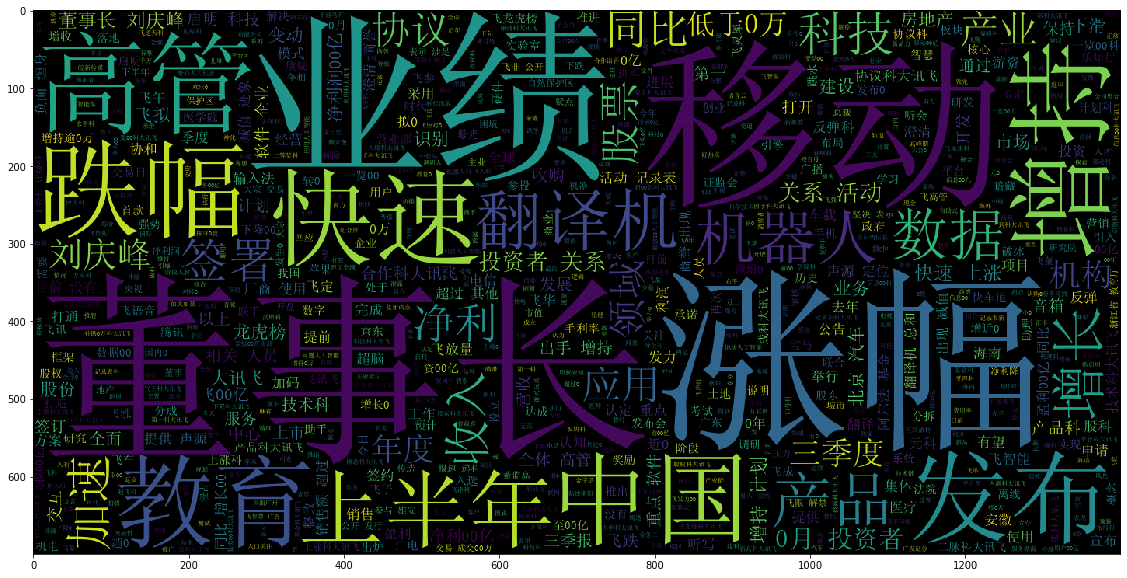

In [48]:
pos_text = df[df['exfuture5']>0.01]['title'].sum()
wc = WordCloud(max_words=800,stopwords=stopwords,font_path='SimSun.ttf',width=1400, height=700, margin=2).generate(pos_text)
plt.figure(figsize=(20,10))
plt.imshow(wc)

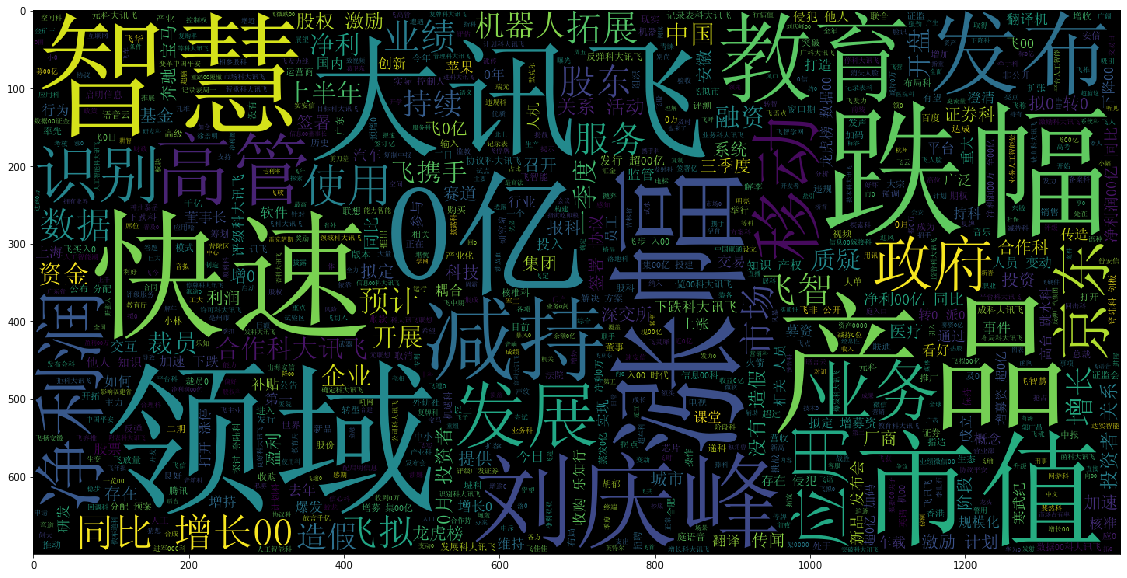

In [53]:
neg_text = df[df['exfuture5']<-0.01]['title'].sum()
wc = WordCloud(max_words=800,stopwords=stopwords,font_path='SimSun.ttf',width=1400, height=700).generate(neg_text)
plt.figure(figsize=(20,10))
plt.imshow(wc)